# Worskhop MLTB
___

##   <span style="color:blue"> Dataset: Brewer's Friend Beer Recipes
    
Es una base que posee todas las recetas de cervezas artesanales registradas en el sitio “Brewer's Friend”. Este sitio web permite a los usuarios compartir sus recetas de cerveza casera. 

Este conjunto de datos contiene 73.861 recetas cargadas. 
La metodología de carga de información en de cada una de las columnas se encuentra estandarizada, con la excepción: “PrimingMethod” (Método de cebado) y “PrimingAmount” (Cantidad de cebado), en donde se les permitie a los usuarios libre tipeo.
    
###   <span style="color:orange">*Objetivo: estimar la graduación alcohólica de las cervezas (“ABV”: Alcohol by Volume) en función de las variables de las recetas.*

In [93]:
# Bread and butter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ML tools
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# ML Models 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

# Others
import missingno
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [73]:
# Levantamos los datasets de test y training.
df_train = pd.read_csv('base_train.csv')
df_test = pd.read_csv('base_test.csv')

In [4]:
df_train.head()

,BeerID,Name,URL,Style,StyleID,Size_L,ABV,IBU,Color,BoilSize,BoilTime,BoilGravity,Efficiency,MashThickness,SugarScale,BrewMethod,PitchRate,PrimaryTemp,PrimingMethod,PrimingAmount
0,69825,DinoSmores Stout,/homebrew/recipe/view/601022/dinosmores-stout,Imperial Stout,87,20.82,8.27,41.30,50.00,28.39,60,1.064,65.0,1.30,Specific Gravity,All Grain,1.25,17.78,NaN,NaN
1,44320,Kinn Gamleguten kopi,/homebrew/recipe/view/486868/kinn-gamleguten-kopi,Old Ale,116,25.00,5.64,35.36,13.28,30.00,60,1.050,65.0,NaN,Specific Gravity,All Grain,0.75,24.00,NaN,NaN
2,55927,American Wheat Beer,/homebrew/recipe/view/501976/american-wheat-beer,American Wheat Beer,14,20.82,5.33,25.18,3.98,24.61,60,1.044,75.0,1.50,Specific Gravity,All Grain,NaN,NaN,NaN,NaN
3,21219,New Fat Mike,/homebrew/recipe/view/322825/new-fat-mike,Double IPA,56,18.93,8.29,91.60,11.74,28.39,60,1.054,70.0,1.25,Specific Gravity,All Grain,0.35,21.11,NaN,NaN
4,18821,Larson Farmhouse Session,/homebrew/recipe/view/314858/larson-farmhouse-...,Saison,134,18.93,4.02,22.81,3.08,26.50,60,1.027,67.0,NaN,Specific Gravity,All Grain,NaN,23.89,NaN,NaN


In [6]:
print(f'Shape de df_training: {df_train.shape}')
print(f'Shape de df_test: {df_test.shape} \n')

# Calculamos proporción del train-test split.
proporcion_train = round(df_train.shape[0] / (df_train.shape[0] + df_test.shape[0]), 2) * 100
proporcion_test = round(df_test.shape[0] / (df_train.shape[0] + df_test.shape[0]), 2) * 100

print('Proporción Train - Test:')
print(f'Train: {proporcion_train}%')
print(f'Test: {proporcion_test}%')

Shape de df_training: (55395, 20)
Shape de df_test: (18466, 19) 

Proporción Train - Test:
Train: 75.0%
Test: 25.0%


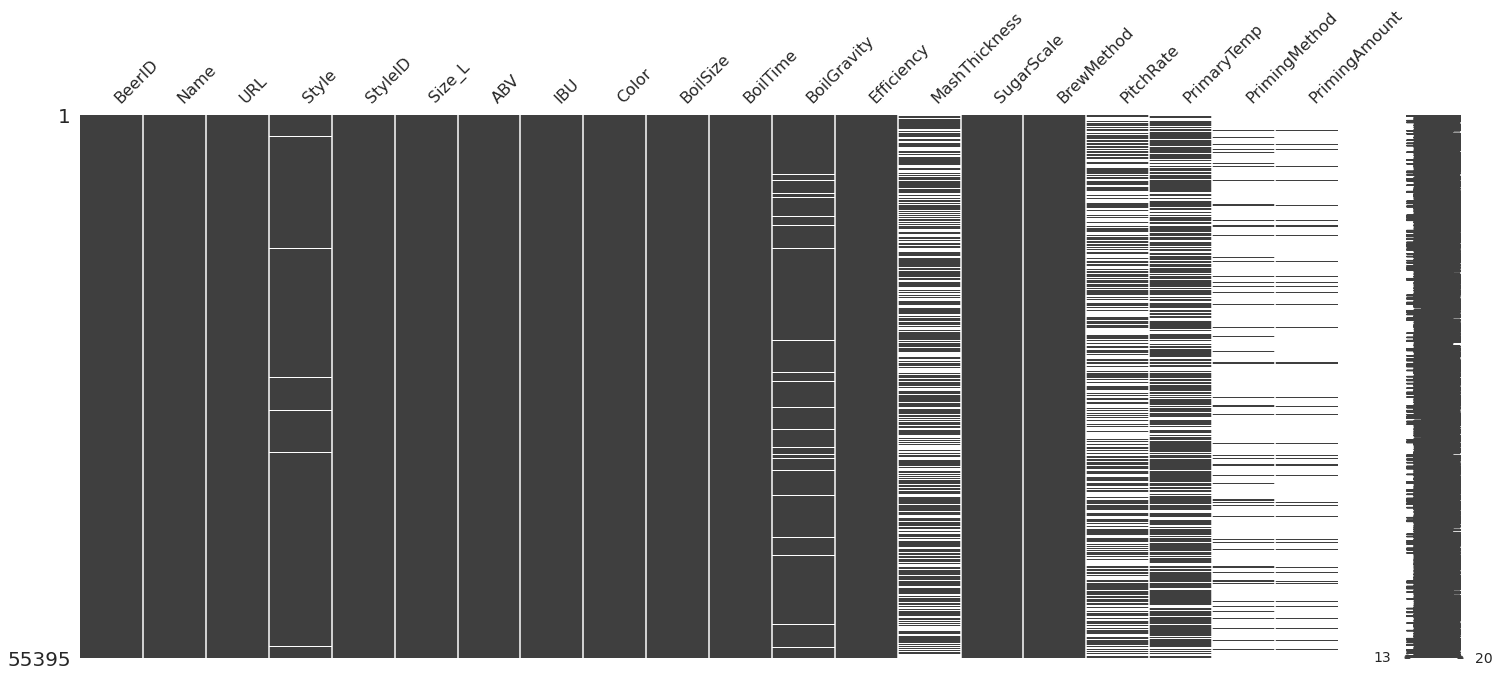

In [213]:
# Graficamos valores faltantes en el dataframe de entrenamiento.
missingno.matrix(df_train)
plt.show()

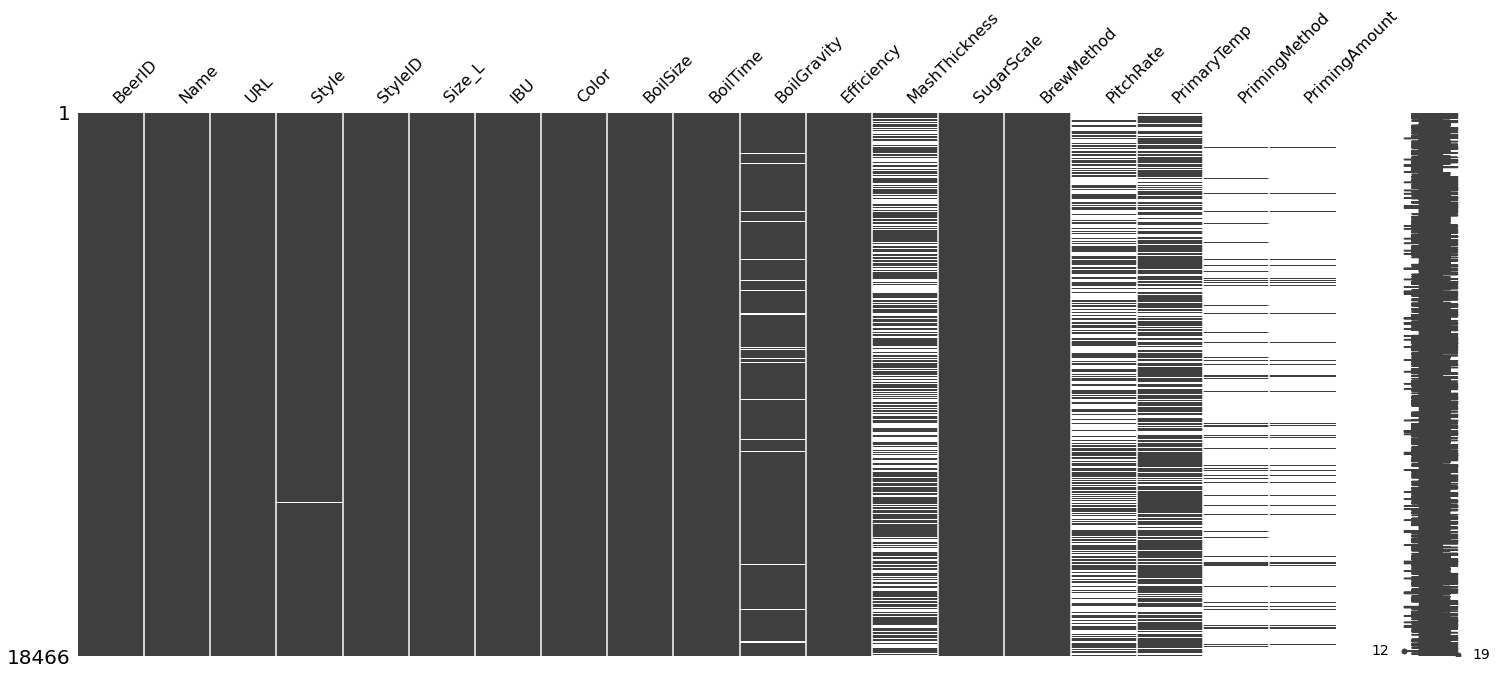

In [7]:
# Graficamos valores falantes en el dataframe de prueba.
missingno.matrix(df_test)
plt.show()

Encontramos varias columnas con valores faltantes.

Conforme avancemos con el análisis tendremos que decidir qué hacer con ellas.

In [215]:
# Característcas cuantitativas del dataframe.
df_train.describe()

,BeerID,StyleID,Size_L,ABV,IBU,Color,BoilSize,BoilTime,BoilGravity,Efficiency,MashThickness,PitchRate,PrimaryTemp
count,55395.000000,55395.000000,55395.000000,55395.000000,55395.000000,55395.000000,55395.000000,55395.000000,53111.000000,55395.000000,32882.000000,25899.000000,38343.000000
mean,36946.534597,60.140157,43.731175,6.134745,44.238239,13.356359,49.505323,65.075566,1.356848,66.344575,2.119151,0.749241,19.176148
std,21374.866695,56.771766,179.667540,1.882808,41.288874,11.871308,192.490886,15.076263,1.931314,14.086639,1.541226,0.394538,4.186520
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-17.780000
25%,18398.500000,10.000000,18.930000,5.070000,23.350000,5.160000,20.820000,60.000000,1.040000,65.000000,1.500000,0.350000,18.000000
50%,36980.000000,35.000000,20.820000,5.790000,35.770000,8.420000,27.440000,60.000000,1.047000,70.000000,1.500000,0.750000,20.000000
75%,55533.500000,111.000000,23.660000,6.830000,56.530000,16.760000,30.000000,60.000000,1.060000,75.000000,3.000000,1.000000,20.000000
max,73861.000000,176.000000,7800.000000,54.720000,3409.300000,186.000000,9130.410000,240.000000,45.900000,100.000000,55.000000,2.000000,114.000000


In [216]:
# Características cualitativas del dataframe.
df_train.describe(include=['O'])

,Name,URL,Style,SugarScale,BrewMethod,PrimingMethod,PrimingAmount
count,55395,55395,54947,55395,55395,5079,3595
unique,45134,55395,175,2,4,731,1557
top,Awesome Recipe,/homebrew/recipe/view/420049/delirious-trembling,American IPA,Specific Gravity,All Grain,Corn Sugar,5 oz
freq,961,1,8986,53947,37200,553,161


De las variables cualitativas observamos que la cuenta de valores únicos **SugarScale** y **BrewMethod** es baja. En consecuencia es probable que sean variables candidatas a ser codificadas para que el modelo pueda trabajar con ellas.

In [217]:
# Correlación entre variables.
df_train.corr()

,BeerID,StyleID,Size_L,ABV,IBU,Color,BoilSize,BoilTime,BoilGravity,Efficiency,MashThickness,PitchRate,PrimaryTemp
BeerID,1.000000,-0.077432,0.003703,-0.052889,-0.014812,-0.045708,0.004791,-0.044491,-0.030138,-0.011322,0.036956,-0.029452,0.001373
StyleID,-0.077432,1.000000,-0.005214,0.004824,-0.145318,0.164246,-0.004953,0.081551,0.001282,0.018227,0.007015,0.076027,-0.021726
Size_L,0.003703,-0.005214,1.000000,-0.014048,-0.031553,-0.016156,0.994181,0.048314,0.169426,0.108724,0.020842,0.033515,-0.000202
ABV,-0.052889,0.004824,-0.014048,1.000000,0.290103,0.272579,-0.009525,0.119621,0.025430,0.048677,-0.074318,0.128668,0.060445
IBU,-0.014812,-0.145318,-0.031553,0.290103,1.000000,0.065228,-0.029591,0.083845,-0.007573,-0.035615,-0.048373,0.003695,0.040557
Color,-0.045708,0.164246,-0.016156,0.272579,0.065228,1.000000,-0.014732,0.059728,0.014218,-0.019922,-0.039481,0.011027,0.026853
BoilSize,0.004791,-0.004953,0.994181,-0.009525,-0.029591,-0.014732,1.000000,0.054524,0.169426,0.121791,0.018938,0.037478,-0.000885
BoilTime,-0.044491,0.081551,0.048314,0.119621,0.083845,0.059728,0.054524,1.000000,0.026652,0.162345,0.010440,0.190132,-0.081385
BoilGravity,-0.030138,0.001282,0.169426,0.025430,-0.007573,0.014218,0.169426,0.026652,1.000000,0.058508,0.054713,0.013142,0.001709
Efficiency,-0.011322,0.018227,0.108724,0.048677,-0.035615,-0.019922,0.121791,0.162345,0.058508,1.000000,0.008233,0.144549,-0.075482


In [218]:
# Generamos una máscara para graficar la matriz de correlación.
# Siendo matriz triangular, la parte inferior muestra la misma data que la superior.
mask = np.zeros_like(df_train.corr())
triangle_indices = np.triu_indices_from(mask)
mask[triangle_indices] = True

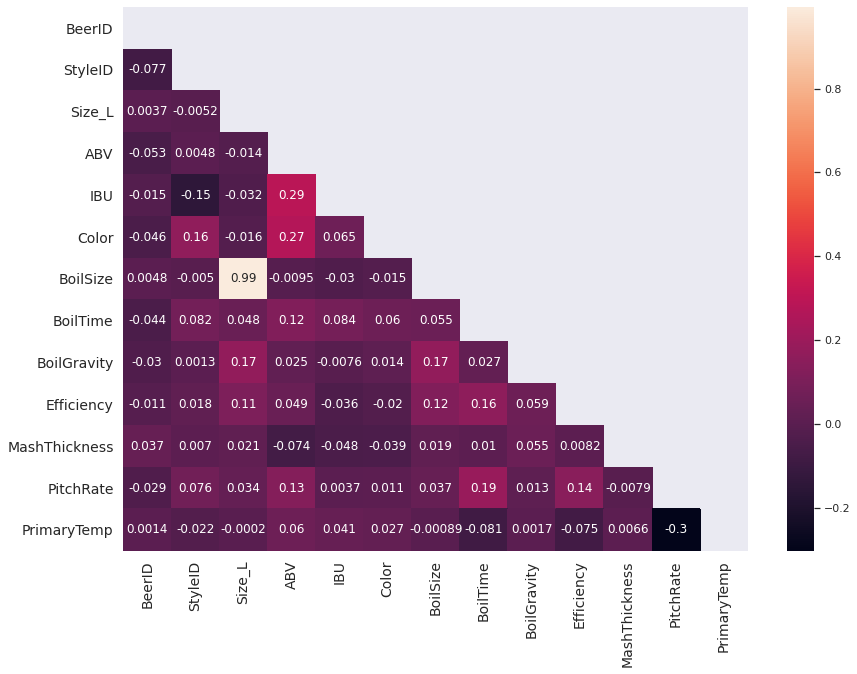

In [219]:
# Gráfico de correlación entre variables
plt.figure(figsize=(14,10))

sns.heatmap(df_train.corr(), 
            mask=mask, 
            annot=True, 
            annot_kws={'size':12})
sns.set_style('white')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

Se destaca una correlación extremadamente alta entre **BoilSize** y **Size_L**.

Procedemos a graficar esta correlación junto con su línea de regresión.

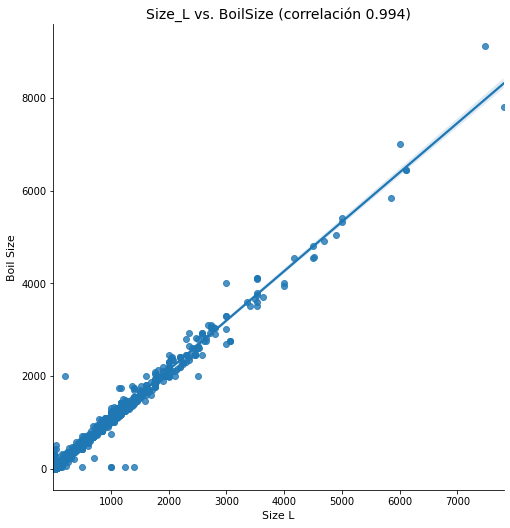

In [8]:
# Calculamos el valor de correlación para incluir en el gráfico
boil_l_corr = round(df_train['Size_L'].corr(df_train['BoilSize']), 3)

sns.lmplot(x='Size_L', y='BoilSize', data=df_train, height=7)

plt.xlabel('Size L', fontsize=11)
plt.ylabel('Boil Size', fontsize=11)
plt.title(f'Size_L vs. BoilSize (correlación {boil_l_corr})', fontsize=14)

plt.show()

Buscamos la definición de estas variables para entender mejor su relación:

* Size_L: Cantidad de litros por Preparación
* BoilSize: Cantidad de Litros al Comenzar la cocción

Dada la naturaleza de ambas variables tiene sentido que su relación tienda a ser líneal. Esta característica puede resultarnos útil de cara a la predicción.

## Variables Cualitativas
___

Comenzamos recordando la cantidad de valores faltantes.

In [9]:
df_train[['Name', 'URL', 'Style', 'SugarScale', 'BrewMethod', 'PrimingMethod', 'PrimingAmount']].isna().sum()

Name                 0
URL                  0
Style              448
SugarScale           0
BrewMethod           0
PrimingMethod    50316
PrimingAmount    51800
dtype: int64

Procedemos a dropear las variables que contienen demasiados faltantes o cuya cantidad de valores únicos las vuelve difíciles de trabajar.

Queda pendiente analizar si es posible extraer información útil de las mismas.

Nos quedaremos con las dos variables cualitativas que podemos codificar.

In [74]:
# Guardo la variable BeerID en un nuevo dataframe.
df_final = pd.DataFrame()
df_final['BeerID'] = df_test['BeerID']

# Dropeo en ambos datasets las columnas que no utilizaré para la predicción.
df_train = df_train.drop(columns=['BeerID', 'Name', 'URL', 'Style', 'PrimingMethod', 'PrimingAmount'])
df_test = df_test.drop(columns=['BeerID', 'Name', 'URL', 'Style', 'PrimingMethod', 'PrimingAmount'])

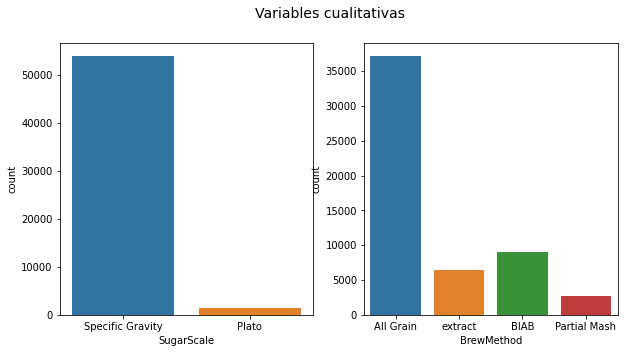

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.countplot(x=df_train['SugarScale'], ax=axes[0])
sns.countplot(x=df_train['BrewMethod'], ax=axes[1])

plt.suptitle('Variables cualitativas', size=14)
plt.show()

In [75]:
# Función para aplicar la codificación a los datasets de train y test. 
def dummies(df):
    df_sugar = pd.get_dummies(df['SugarScale'], prefix='sugar')
    df_method = pd.get_dummies(df['BrewMethod'], prefix='method')
    
    df_encoded = df.drop(columns=['SugarScale', 'BrewMethod'], axis=0)

    # We add all the encoded df to our new df
    df_encoded = pd.concat([df_encoded, df_sugar, df_method], axis=1)
    
    return df_encoded

In [76]:
df_train = dummies(df_train)
df_test = dummies(df_test)

In [77]:
# Revisamos las columnas del dataset
df_train.columns

Index(['StyleID', 'Size_L', 'ABV', 'IBU', 'Color', 'BoilSize', 'BoilTime',
       'BoilGravity', 'Efficiency', 'MashThickness', 'PitchRate',
       'PrimaryTemp', 'sugar_Plato', 'sugar_Specific Gravity',
       'method_All Grain', 'method_BIAB', 'method_Partial Mash',
       'method_extract'],
      dtype='object')

## Variables Cuantitativas
___

Recordamos valores faltantes y su proporción en relación al total de datos.

In [94]:
for column in ['BoilGravity', 'MashThickness', 'PitchRate', 'PrimaryTemp']:
    print(column + f': {round(df_train[column].isna().sum() / df_train.shape[0], 2) * 100} %')

BoilGravity: 4.0 %
MashThickness: 41.0 %
PitchRate: 53.0 %
PrimaryTemp: 31.0 %


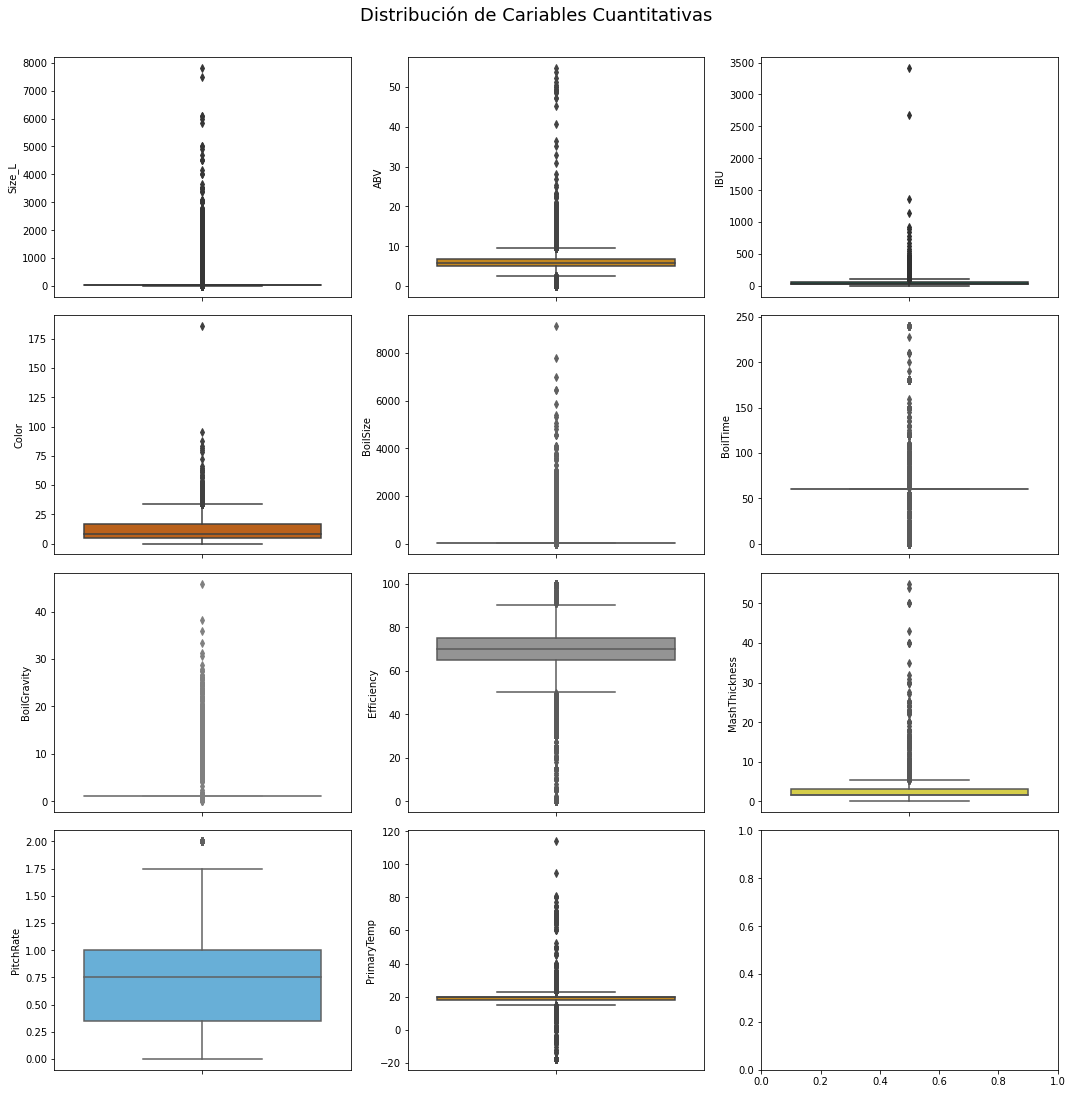

In [42]:
# Boxplot
colors = sns.color_palette('colorblind')

fig, axes = plt.subplots(4, 3, figsize=(15, 15))

sns.boxplot(y=df_train['Size_L'], color=colors[0], ax=axes[0,0])
sns.boxplot(y=df_train['ABV'], color=colors[1], ax=axes[0,1])
sns.boxplot(y=df_train['IBU'], color=colors[2], ax=axes[0,2])
sns.boxplot(y=df_train['Color'], color=colors[3], ax=axes[1,0])
sns.boxplot(y=df_train['BoilSize'], color=colors[4], ax=axes[1,1])
sns.boxplot(y=df_train['BoilTime'], color=colors[5], ax=axes[1,2])
sns.boxplot(y=df_train['BoilGravity'], color=colors[6], ax=axes[2,0])
sns.boxplot(y=df_train['Efficiency'], color=colors[7], ax=axes[2,1])
sns.boxplot(y=df_train['MashThickness'], color=colors[8], ax=axes[2,2])
sns.boxplot(y=df_train['PitchRate'], color=colors[9], ax=axes[3,0])
sns.boxplot(y=df_train['PrimaryTemp'], color=colors[1], ax=axes[3,1])

plt.suptitle('Distribución de Cariables Cuantitativas', y=1.01, size=18)
plt.tight_layout()
plt.show()

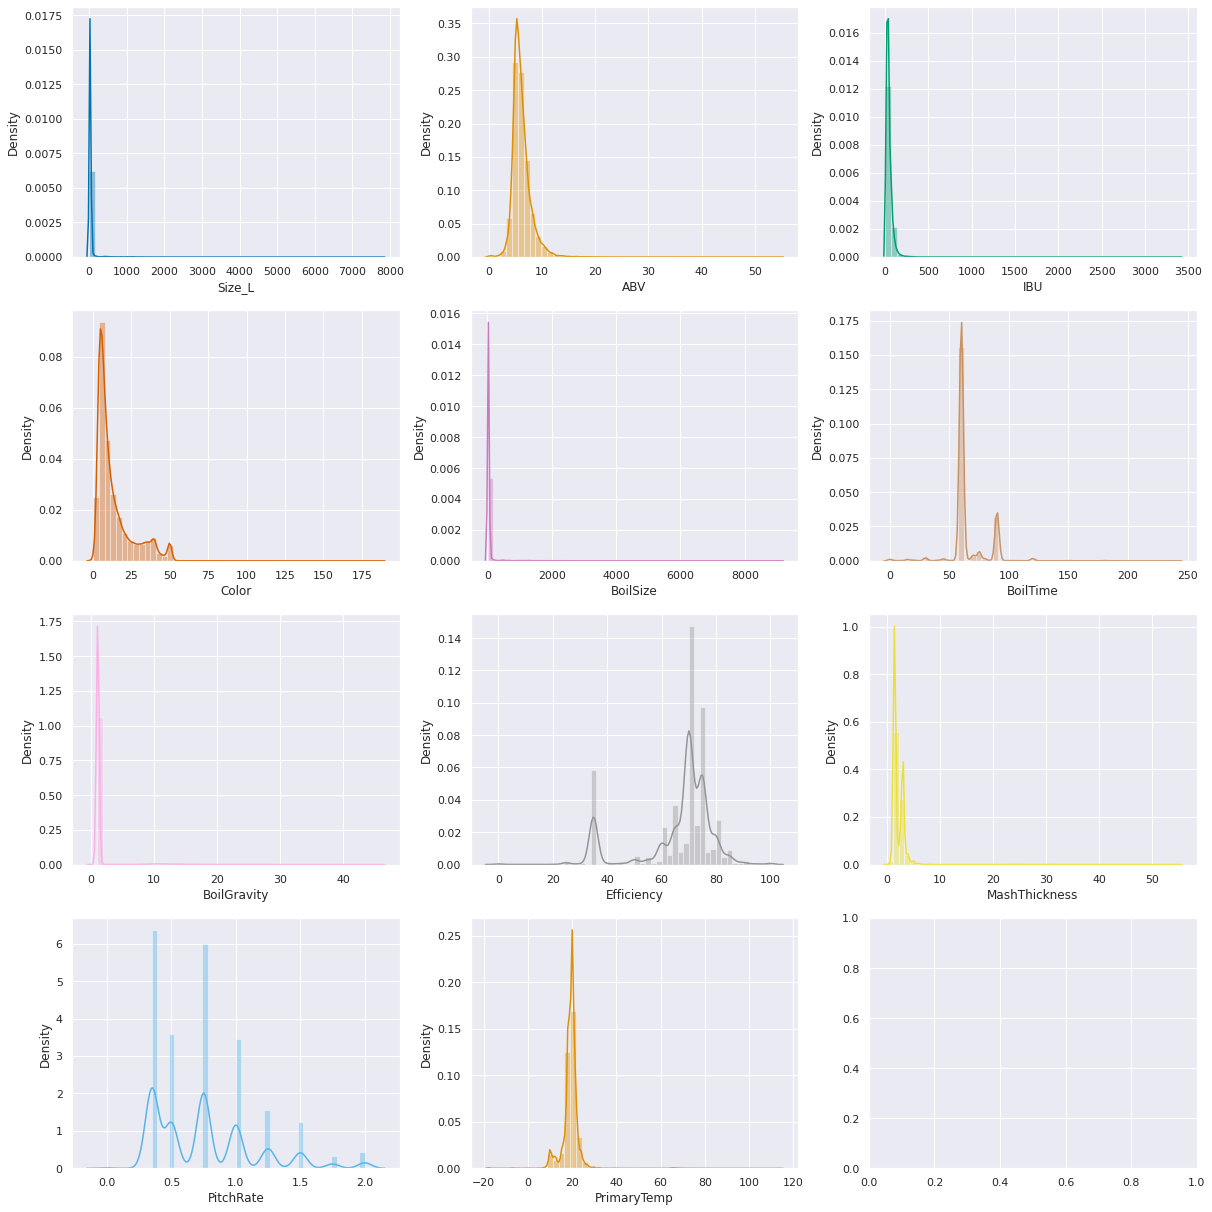

In [95]:
# Distplot
sns.set(color_codes=True)
colors = sns.color_palette('colorblind')

fig, axes = plt.subplots(4, 3, figsize=(17, 17))

sns.distplot(df_train['Size_L'], color=colors[0], ax=axes[0,0])
sns.distplot(df_train['ABV'], color=colors[1], ax=axes[0,1])
sns.distplot(df_train['IBU'], color=colors[2], ax=axes[0,2])
sns.distplot(df_train['Color'], color=colors[3], ax=axes[1,0])
sns.distplot(df_train['BoilSize'], color=colors[4], ax=axes[1,1])
sns.distplot(df_train['BoilTime'], color=colors[5], ax=axes[1,2])
sns.distplot(df_train['BoilGravity'], color=colors[6], ax=axes[2,0])
sns.distplot(df_train['Efficiency'], color=colors[7], ax=axes[2,1])
sns.distplot(df_train['MashThickness'], color=colors[8], ax=axes[2,2])
sns.distplot(df_train['PitchRate'], color=colors[9], ax=axes[3,0])
sns.distplot(df_train['PrimaryTemp'], color=colors[1], ax=axes[3,1])

plt.tight_layout()
plt.show()

**PitchRate** es la única variable que no presenta una cantidad elevada de outliers.

### Completando variables faltantes

Utilizaremos una función de pandas llamada **interpolate**. Esta función completa los valores faltantes utilizando interpolación lineal. En este caso usamos el valor por defecto que es "linear". Para más información, ingresar en la [documentación](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html) de pandas.

Construiremos tres datasets: 

* **df_train_full**: utiliza todas las variables, incluso las que poseen un número elevado de valores faltantes
* **df_train_less**: dropea las columnas con muchos valores faltantes
* **df_train_none**: dropea todas las columnas con valores faltantes

In [78]:
df_train_full = df_train.interpolate()
df_test_full = df_test.interpolate()

df_train_less = df_train.drop(columns=['MashThickness', 'PitchRate'])
df_test_less = df_test.drop(columns=['MashThickness', 'PitchRate'])
df_train_less = df_train_less.interpolate()
df_test_less = df_test_less.interpolate()

df_train_none = df_train.drop(columns=['BoilGravity', 'MashThickness', 'PitchRate', 'PrimaryTemp'])
df_test_none = df_test.drop(columns=['BoilGravity', 'MashThickness', 'PitchRate', 'PrimaryTemp'])

In [79]:
df_test_less.head()

,StyleID,Size_L,IBU,Color,BoilSize,BoilTime,BoilGravity,Efficiency,PrimaryTemp,sugar_Plato,sugar_Specific Gravity,method_All Grain,method_BIAB,method_Partial Mash,method_extract
0,10,18.93,31.01,6.01,13.25,50,1.055,35.0,22.220000,0,1,0,0,0,1
1,7,18.93,44.28,4.83,24.61,60,1.040,70.0,20.813333,0,1,0,1,0,0
2,7,22.71,60.95,7.22,30.28,70,1.048,75.0,19.406667,0,1,1,0,0,0
3,10,24.00,20.84,11.86,28.50,60,1.046,80.0,18.000000,0,1,1,0,0,0
4,10,11.36,34.97,7.89,7.57,60,1.090,35.0,18.330000,0,1,0,0,0,1


## El Modelo
___

In [80]:
# Generamos las particiones nacesarias
y_train = df_train_less['ABV']
X_train = df_train_less.drop(columns=['ABV'], axis=1)

# Dada la naturaleza del ejercicio no tenemos un y_test para corroborar la performance
X_test = df_test_less.copy()

Utilizamos **cross_val_score** para probar distintos modelos y acercarnos al que podría funcionar mejor. En este caso probaremos cinco:
* Linear Regression
* Random Forest Regressor
* AdaBoost Regressor
* Decision Tree Regressor
* Gradient Boosting Regressor

A través de este método elegiremos a qué modelo aplicaremos Grid Search.

In [82]:
# Modelos a comparar
models = [
    LinearRegression(),
    RandomForestRegressor(),
    AdaBoostRegressor(),
    DecisionTreeRegressor(),
    GradientBoostingRegressor()
]

# Número de cross-validations
CV = 10
cv_df = pd.DataFrame(index=range(CV*len(models)))
entries = []

for model in models:
    model_name = model.__class__.__name__
    accuaracies = cross_val_score(model, X_train, y_train, scoring='r2', cv=CV)
    for fold_idx, accuaracy in enumerate(accuaracies):
        entries.append((model_name, fold_idx, accuaracy))
        
# Datagrame final con resultados de performance
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'r2'])

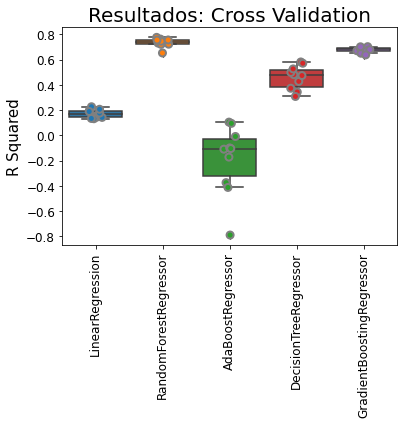

In [86]:
sns.boxplot(x='model_name', y='r2', data=cv_df)
sns.stripplot(x='model_name', y='r2', data=cv_df, size=7, jitter=True, edgecolor='grey', linewidth=2)
plt.title('Resultados: Cross Validation', fontsize=20)
plt.xlabel('')
plt.ylabel('R Squared', fontsize=15)
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12, rotation=0)
plt.show()

In [84]:
final_comp = (cv_df
             .groupby('model_name')
             .r2
             .mean()
             .reset_index()
             .sort_values(by='r2', ascending=False))

final_comp

,model_name,r2
4,RandomForestRegressor,0.735736
2,GradientBoostingRegressor,0.677448
1,DecisionTreeRegressor,0.458163
3,LinearRegression,0.170206
0,AdaBoostRegressor,-0.187247


A continuación aplicaremos **GridSearchCV** para obtener los mejores parámetros para optimizar la performance de nuestro modelo.

Utilizaremos este método sobre **Random Forest Regressor** ya fue el que mejor rankeo de los modelos testeados.

Se presenta el código comentado debajo. Tener en cuenta que el mismo realiza 1080 iteraciones del modelo y por tanto tarda mucho en correr.

In [85]:
"""
regressor = RandomForestRegressor(random_state=14)


grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [20, 50, 100]
}

grid_apply = GridSearchCV(regressor, grid, scoring='r2', cv=5, refit=True, verbose=2)
"""

"\nregressor = RandomForestRegressor(random_state=14)\n\n\ngrid = {\n    'bootstrap': [True],\n    'max_depth': [80, 90, 100, 110],\n    'max_features': [2, 3],\n    'min_samples_leaf': [3, 4, 5],\n    'min_samples_split': [8, 10, 12],\n    'n_estimators': [20, 50, 100]\n}\n\ngrid_apply = GridSearchCV(regressor, grid, scoring='r2', cv=5, refit=True, verbose=2)\n"

In [86]:
# grid_apply.fit(X_train, y_train)

In [87]:
"""
best_perf = grid_apply.best_score_
best_model = grid_apply.best_params_

print(f'Best R Squared: {str(best_perf)}')
print()
print(f'Best Parameters: {str(best_model)}')
"""

"\nbest_perf = grid_apply.best_score_\nbest_model = grid_apply.best_params_\n\nprint(f'Best R Squared: {str(best_perf)}')\nprint()\nprint(f'Best Parameters: {str(best_model)}')\n"

**Los parámetros utilizados debajo son los mejores que encontré cuando realicé mi análisis.**

In [87]:
regressor = RandomForestRegressor(
    random_state=14,
    bootstrap=True, 
    max_depth=80, 
    max_features=3,
    min_samples_leaf=3,
    min_samples_split=10,
    n_estimators=100
    )

regressor.fit(X_train, y_train)
y_hat = regressor.predict(X_test)

In [89]:
y_hat

array([5.44038958, 5.54536509, 6.40011026, ..., 5.21233091, 3.67837483,
       4.58234062])

In [90]:
# Asigno al df generado más arriba las variables predecidas.
df_final['ABV'] = y_hat

In [91]:
df_final.head()

,BeerID,ABV
0,47061,5.440390
1,26902,5.545365
2,1166,6.400110
3,70996,5.533078
4,6657,5.446880


In [92]:
# Exporto la predicción como .csv
df_final.to_csv('predicciones.csv')

___